In [3]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import community
from IPython import display

%matplotlib inline

In [4]:
# random small-world networks
s = 3 # for reproducibility

# parameters -> change these to generate random graphs with (somewhat) different properties
n = 20 # number of nodes
k = 4 # WS: number of nearest neighbors to join
p = .1 # WS: probability of: adding a new edge (NWS), rewiring an existing edge (WS)
#m = 5 # BA: number of edges to attach from a new node to an existing node (1 <= m < n)
#p_hk = .001 # HK: probability of adding a triangle after adding a random edge

# create the actual random graph
#nws_network = nx.newman_watts_strogatz_graph(n,k,p,seed=s)
#ws_network = nx.watts_strogatz_graph(n,k,p,seed=s)
cws_network = nx.connected_watts_strogatz_graph(n,k,p,seed=s) # for guaranteeing a connected graph
#ba_network = nx.barabasi_albert_graph(n,m,seed=s)
#hk_network = nx.powerlaw_cluster_graph(n,m,p_hk,seed=s) # BA model w/ addl prob of triangles at each time step
#kleinberg_network = nx.navigable_small_world_graph() # ???

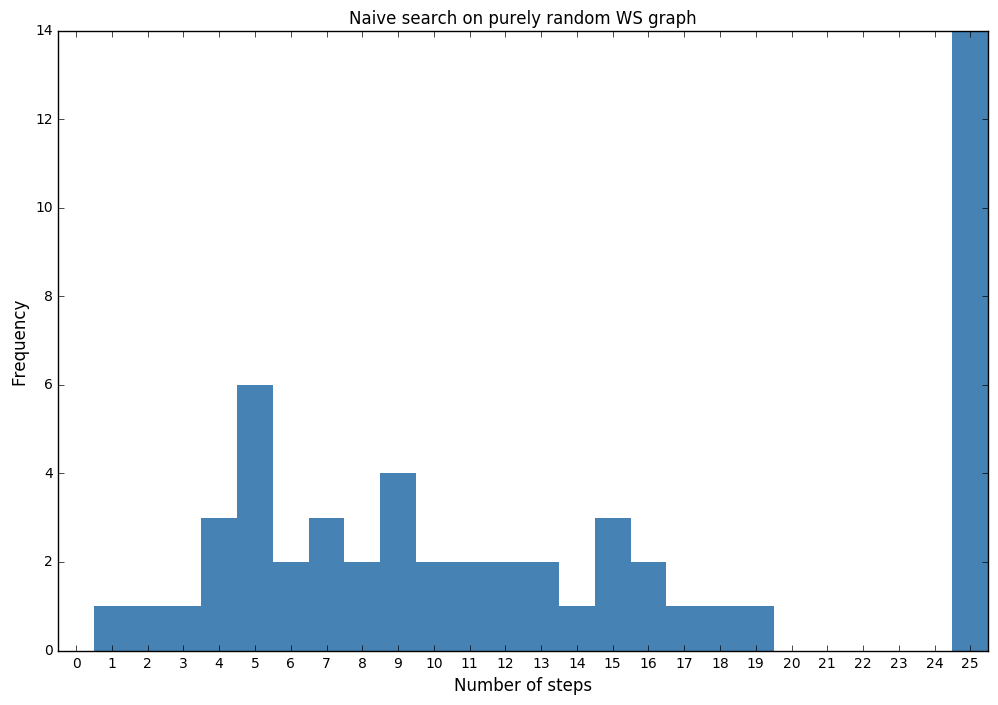

In [ ]:
# choosing complete for simplicity: guaranteed to have a path
G = cws_network # choose a network type to visualize
pos = nx.random_layout(G)

# set up drawing
#fig, ax = plt.subplots(2,1,figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,8))
#ax.set_aspect('equal'); ax.hold(True)
bins=np.arange(-0.5,26.5)

n_sim = 100 # specify number of simulations to run
results = list()

#background = fig.canvas.copy_from_bbox(ax.bbox)

# Naive search on purely random network
for j in range(n_sim):
    # set edge attributes
    explored = dict()
    for e in G.edges(): explored[e] = 0
    nx.set_edge_attributes(G,'explored',explored)

    # set node attributes
    discovered = dict()
    for n in G.nodes(): discovered[n] = 0
    nx.set_node_attributes(G,'discovered',discovered)

    # determine random start and target nodes
    start = random.randint(1,n); target = random.randint(1,n)
    while start == target: target = random.randint(1,n)
    
    n_queue = list(); n_queue.append(start)
    current = n_queue.pop(0); t = 0 
    discovered[current] = 1; nx.set_node_attributes(G,'discovered',discovered)
    
    #print("simulation ", j)
    #print("starting node = ", start, "target node = ", target)
    while current != target:
        # pick random unvisited neighbor to visit next
        incident_edges = G.edges(current); d = len(incident_edges)
        idx = random.randint(0,d-1); next_node = incident_edges[idx][1]; i = idx
        while discovered[next_node] == 1:
            i = (i+1)%d; next_node = incident_edges[i][1]
            if i == idx: t = 25; break
        n_queue.append(next_node)

        if t == 25: break
        
        # update attributes
        if (current,next_node) in G.edges(): traversed_edge = (current,next_node)
        else: traversed_edge = (next_node,current)
        explored[traversed_edge] = 1; discovered[next_node] = 1
        nx.set_node_attributes(G,'discovered',discovered)
        nx.set_edge_attributes(G,'explored',explored)

        # get current attributes
        node_list,node_discovered = zip(*discovered.items())
        edge_list,edge_explored = zip(*explored.items())

        # visualize current step (SLOW)
#         plt.subplot(2,1,1)
#         fig.canvas.restore_region(background)
#         nx.draw_networkx_nodes(G,pos,node_size=500,node_color=node_discovered)
#         nx.draw_networkx_labels(G,pos,font_size=12,font_color='white')
#         nx.draw_networkx_edges(G,pos,edge_color=edge_explored,edgelist=edge_list)
#         fig.canvas.blit(ax.bbox)
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        
        
        #print("current = ",current,"traversed = ", traversed_edge, "next = ", next_node)

        # get next node to visit
        current = n_queue.pop(0); t += 1
    
    results.append(t)
    
    # dynamically update histogram plot of results
    plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
    plt.xticks(np.arange(0,26))
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.title("Naive search on purely random WS graph")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# show final histogram of overall simulation results
# plt.subplot(2,1,2)
# plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
# plt.xticks(np.arange(0,26))
# plt.xlabel('Number of steps',fontsize=12)
# plt.ylabel('Frequency',fontsize=12)
# plt.title("Naive search on purely random WS graph")
# plt.show()

In [4]:
print("Naive search on random WS network results:")
print("mean number of steps:",np.mean(results))
print("median number of steps:",np.median(results))

Naive search on random WS network results:
('mean number of steps:', 13.33)
('median number of steps:', 12.0)


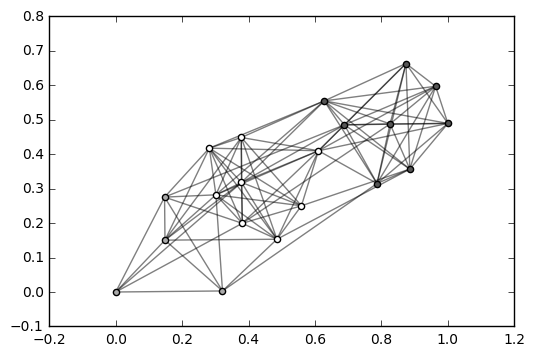

In [5]:
# create new graph clustered by similarity
G.remove_edges_from(G.edges())

# randomly assign nodes to clusters
num_clusters = 3; # honestly just making this up
clusters = dict()
for n in G.nodes(): clusters[n] = random.randint(0,num_clusters-1)
nx.set_node_attributes(G,'cluster',clusters)

# generate edges to cluster network properly
for n in G.nodes():
    for m in G.nodes():
        if clusters[n] == clusters[m]: G.add_edge(n,m)
        else:
            if random.random() <= p: G.add_edge(n,m)
                
# using Community module
partition = community.best_partition(G) # partition by Louvain method

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

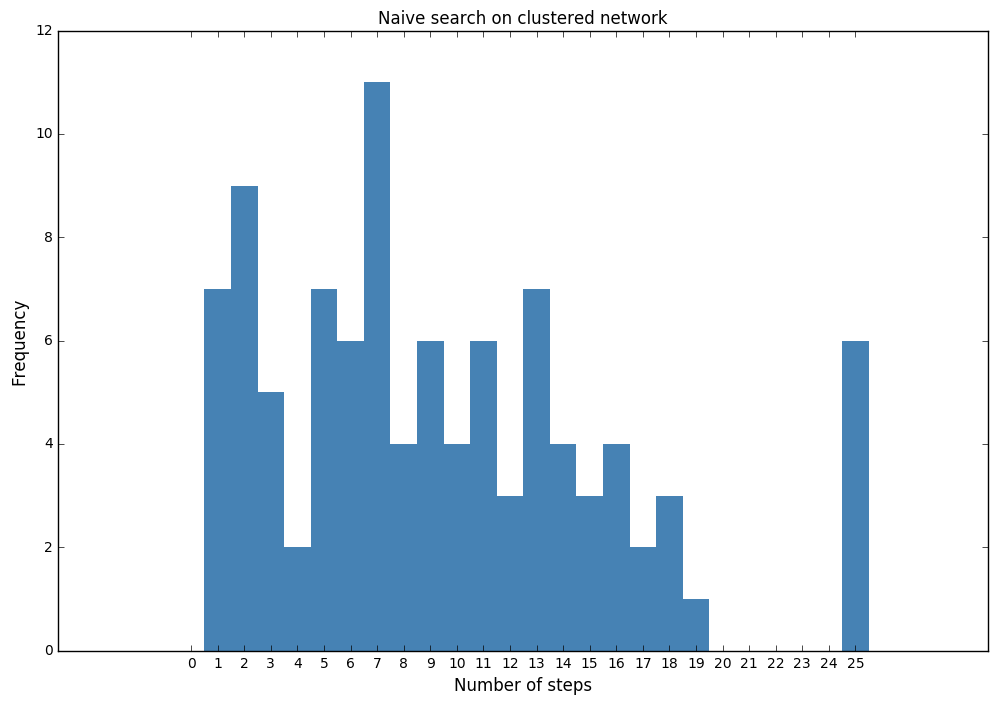

In [6]:
# set up drawing
#fig, ax = plt.subplots(2,1,figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,8))
#ax.set_aspect('equal'); ax.hold(True)
bins=np.arange(-0.5,26.5)

n_sim = 100 # specify number of simulations to run
results = list()

# background = fig.canvas.copy_from_bbox(ax.bbox)

# Naive search on network clustered by similarity
for j in range(n_sim):
    # set edge attributes
    explored = dict()
    for e in G.edges(): explored[e] = 0
    nx.set_edge_attributes(G,'explored',explored)

    # set node attributes
    discovered = dict()
    for n in G.nodes(): discovered[n] = 0
    nx.set_node_attributes(G,'discovered',discovered)

    # determine random start and target nodes
    start = random.randint(1,n); target = random.randint(1,n)
    while start == target: target = random.randint(1,n)

    n_queue = list(); n_queue.append(start)
    current = n_queue.pop(0); t = 0 
    discovered[current] = 1; nx.set_node_attributes(G,'discovered',discovered)
    
    #print("simulation ", j)
    #print("starting node = ", start, "target node = ", target)
    while current != target:
        # pick random unvisited neighbor to visit next
        incident_edges = G.edges(current); d = len(incident_edges)
        idx = random.randint(0,d-1); next_node = incident_edges[idx][1]; i = idx
        while discovered[next_node] == 1:
            i = (i+1)%d; next_node = incident_edges[i][1]
            if i == idx: t = 25; break
        n_queue.append(next_node)
        
        if t == 25: break

        # update attributes
        if (current,next_node) in G.edges(): traversed_edge = (current,next_node)
        else: traversed_edge = (next_node,current)
        explored[traversed_edge] = 1; discovered[next_node] = 1
        nx.set_node_attributes(G,'discovered',discovered)
        nx.set_edge_attributes(G,'explored',explored)

        # get current attributes
        node_list,node_discovered = zip(*discovered.items())
        edge_list,edge_explored = zip(*explored.items())
        
        # visualize current step (SLOW)
#         plt.subplot(2,1,1)
#         fig.canvas.restore_region(background)
#         nx.draw_networkx_nodes(G,pos,node_size=500,node_color=node_discovered)
#         nx.draw_networkx_labels(G,pos,font_size=12,font_color='white')
#         nx.draw_networkx_edges(G,pos,edge_color=edge_explored,edgelist=edge_list)
#         fig.canvas.blit(ax.bbox)
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        
        
        #print("current = ",current,"traversed = ", traversed_edge, "next = ", next_node)

        # get next node to visit
        current = n_queue.pop(0); t += 1
    
    results.append(t)
    plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
    plt.xticks(np.arange(0,26))
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.title("Naive search on clustered network")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# show final histogram of overall simulation results
# plt.subplot(2,1,2)
# plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
# plt.xticks(np.arange(0,26))
# plt.xlabel('Number of steps',fontsize=12)
# plt.ylabel('Frequency',fontsize=12)
# plt.title("Naive search on clustered network")
# plt.show()

In [12]:
print("Naive search on clustered network results:")
print("mean number of steps:",np.mean(results))
print("median number of steps:",np.median(results))

Naive search on clustered network results:
('mean number of steps:', 11.550000000000001)
('median number of steps:', 10.0)


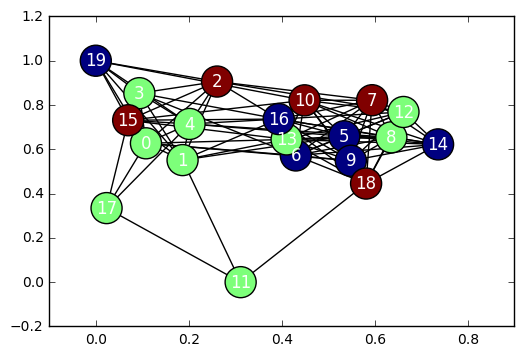

In [8]:
# directed search on random network
G = cws_network

# randomly assign nodes to clusters
num_clusters = 3 # honestly just making this up
clusters = dict()
for n in G.nodes(): clusters[n] = random.randint(0,num_clusters-1)
nx.set_node_attributes(G,'cluster',clusters)

# draw
node_list,cluster = zip(*clusters.items())
nx.draw_networkx_nodes(G,pos,node_size=500,node_color=cluster,nodelist=node_list)
nx.draw_networkx_labels(G,pos,font_size=12,font_color='white')
nx.draw_networkx_edges(G,pos,edge_color='black')

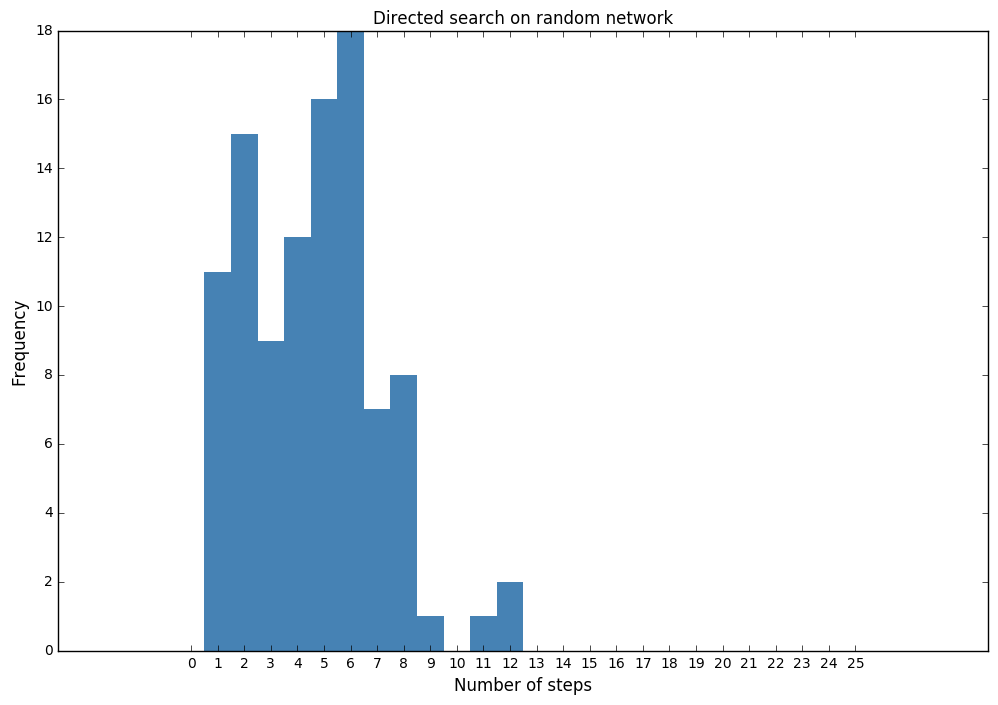

In [15]:
# set up drawing
#fig, ax = plt.subplots(2,1,figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,8))
#ax.set_aspect('equal'); ax.hold(True)
bins=np.arange(-0.5,26.5)

# background = fig.canvas.copy_from_bbox(ax.bbox)

n_sim = 100 # specify number of simulations to run
results = list()

# Directed search on random network
for j in range(n_sim):
    # set edge attributes
    explored = dict()
    for e in G.edges(): explored[e] = 0
    nx.set_edge_attributes(G,'explored',explored)

    # set node attributes
    discovered = dict()
    for n in G.nodes(): discovered[n] = 0
    nx.set_node_attributes(G,'discovered',discovered)

    # determine random start and target nodes
    start = random.randint(1,n); target = random.randint(1,n)
    while start == target: target = random.randint(1,n)

    n_queue = list(); n_queue.append(start)
    current = n_queue.pop(0); t = 0 
    discovered[current] = 1; nx.set_node_attributes(G,'discovered',discovered)
    
    #print("simulation ", j)
    #print("starting node = ", start, "target node = ", target)
    while current != target:
        # pick unvisited neighbor "closest to target" to visit next
        incident_edges = G.edges(current); d = len(incident_edges)
        idx = random.randint(0,d-1); next_node = incident_edges[idx][1]; i = idx        
        while discovered[next_node] == 1:
            i = (i+1)%d; next_node = incident_edges[i][1]
            if i == idx: t = 25; break
        for u,v in incident_edges: # pick next node "most similar" to target if available
            if cluster[v] == cluster[target] and discovered[v] == 0: next_node = v; break
        n_queue.append(next_node)
        
        if t == 25: break

        # update attributes
        if (current,next_node) in G.edges(): traversed_edge = (current,next_node)
        else: traversed_edge = (next_node,current)
        explored[traversed_edge] = 1; discovered[next_node] = 1
        nx.set_node_attributes(G,'discovered',discovered)
        nx.set_edge_attributes(G,'explored',explored)

        # get current attributes
        node_list,node_discovered = zip(*discovered.items())
        edge_list,edge_explored = zip(*explored.items())

        # visualize current step (SLOW)
#         plt.subplot(2,1,1)
#         fig.canvas.restore_region(background)
#         nx.draw_networkx_nodes(G,pos,node_size=500,node_color=node_discovered)
#         nx.draw_networkx_labels(G,pos,font_size=12,font_color='white')
#         nx.draw_networkx_edges(G,pos,edge_color=edge_explored,edgelist=edge_list)
#         fig.canvas.blit(ax.bbox)
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        
        #print("current = ",current,"traversed = ", traversed_edge, "next = ", next_node)

        # get next node to visit
        current = n_queue.pop(0); t += 1
    
    results.append(t)
    plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
    plt.xticks(np.arange(0,26))
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.title("Directed search on random network")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# show final histogram of overall simulation results
# plt.subplot(2,1,2)
# plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
# plt.xticks(np.arange(0,26))
# plt.xlabel('Number of steps',fontsize=12)
# plt.ylabel('Frequency',fontsize=12)
# plt.title("Directed search on random network")
# plt.show()

In [16]:
print("Directed search on random network results:")
print("mean number of steps:",np.mean(results))
print("median number of steps:",np.median(results))

Directed search on random network results:
('mean number of steps:', 4.6100000000000003)
('median number of steps:', 5.0)


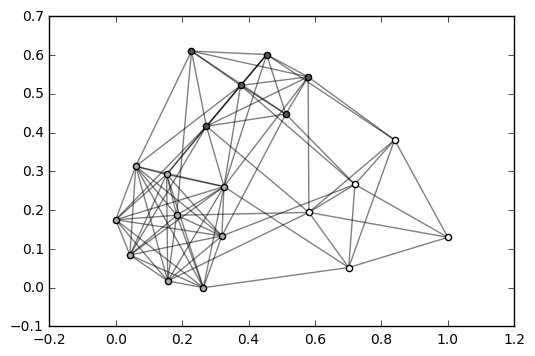

In [9]:
G = cws_network

# create new graph clustered by similarity
G.remove_edges_from(G.edges())

# randomly assign nodes to clusters
num_clusters = 3; # honestly just making this up
clusters = dict()
for n in G.nodes(): clusters[n] = random.randint(0,num_clusters-1)
nx.set_node_attributes(G,'cluster',clusters)

# generate edges to cluster network properly
for n in G.nodes():
    for m in G.nodes():
        if clusters[n] == clusters[m]: G.add_edge(n,m)
        else:
            if random.random() <= p: G.add_edge(n,m)
                
# using Community module
partition = community.best_partition(G) # partition by Louvain method

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

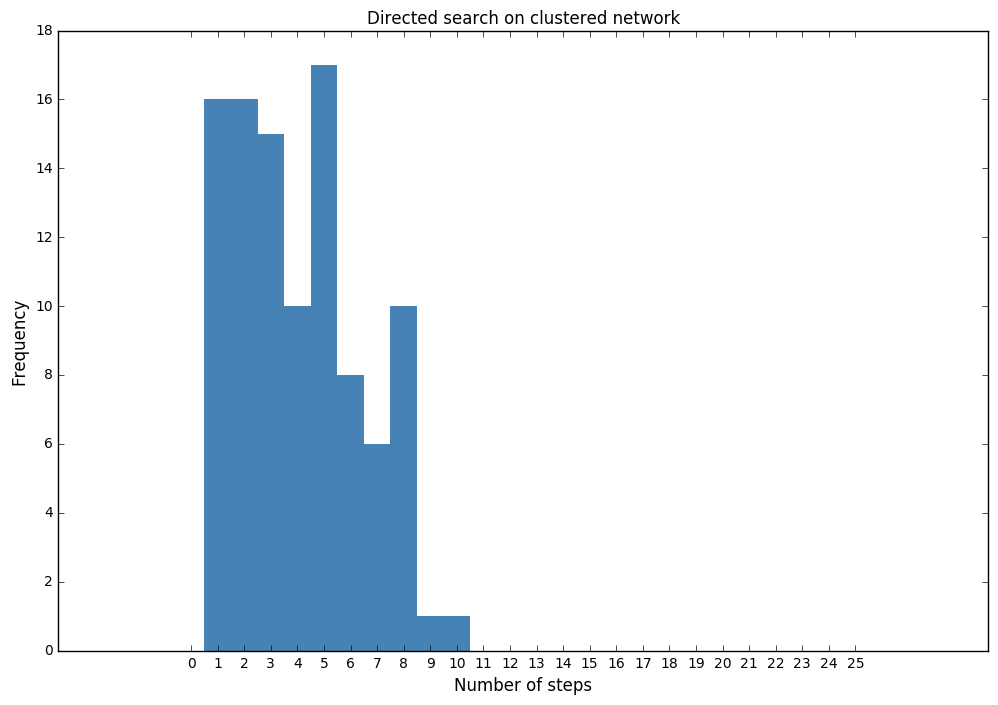

In [10]:
# set up drawing
#fig, ax = plt.subplots(2,1,figsize=(12,12))
fig, ax = plt.subplots(figsize=(12,8))
#ax.set_aspect('equal'); ax.hold(True)
bins=np.arange(-0.5,26.5)

background = fig.canvas.copy_from_bbox(ax.bbox)

n_sim = 100 # specify number of simulations to run
results = list()

# Directed search on clustered network
for j in range(n_sim):
    # set edge attributes
    explored = dict()
    for e in G.edges(): explored[e] = 0
    nx.set_edge_attributes(G,'explored',explored)

    # set node attributes
    discovered = dict()
    for n in G.nodes(): discovered[n] = 0
    nx.set_node_attributes(G,'discovered',discovered)

    # determine random start and target nodes
    start = random.randint(1,n); target = random.randint(1,n)
    while start == target: target = random.randint(1,n)

    n_queue = list(); n_queue.append(start)
    current = n_queue.pop(0); t = 0 
    discovered[current] = 1; nx.set_node_attributes(G,'discovered',discovered)
    
    #print("simulation ", j)
    #print("starting node = ", start, "target node = ", target)
    while current != target:
        # pick unvisited neighbor "closest to target" to visit next
        incident_edges = G.edges(current); d = len(incident_edges)
        idx = random.randint(0,d-1); next_node = incident_edges[idx][1]; i = idx        
        while discovered[next_node] == 1:
            i = (i+1)%d; next_node = incident_edges[i][1]
            if i == idx: t = 25; break
        for u,v in incident_edges: # pick next node "most similar" to target if available
            if clusters[v] == clusters[target] and discovered[v] == 0: next_node = v; break
        n_queue.append(next_node)
        
        if t == 25: break

        # update attributes
        if (current,next_node) in G.edges(): traversed_edge = (current,next_node)
        else: traversed_edge = (next_node,current)
        explored[traversed_edge] = 1; discovered[next_node] = 1
        nx.set_node_attributes(G,'discovered',discovered)
        nx.set_edge_attributes(G,'explored',explored)

        # get current attributes
        node_list,node_discovered = zip(*discovered.items())
        edge_list,edge_explored = zip(*explored.items())

        # visualize current step (SLOW)
#         plt.subplot(2,1,1)
#         fig.canvas.restore_region(background)
#         nx.draw_networkx_nodes(G,pos,node_size=500,node_color=node_discovered)
#         nx.draw_networkx_labels(G,pos,font_size=12,font_color='white')
#         nx.draw_networkx_edges(G,pos,edge_color=edge_explored,edgelist=edge_list)
#         fig.canvas.blit(ax.bbox)
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
        
        #print("current = ",current,"traversed = ", traversed_edge, "next = ", next_node)

        # get next node to visit
        current = n_queue.pop(0); t += 1
    
    results.append(t)
    plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
    plt.xticks(np.arange(0,26))
    plt.xlabel('Number of steps',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.title("Directed search on clustered network")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# show final histogram of overall simulation results
# plt.subplot(2,1,2)
# plt.hist(results,bins=bins,color='steelblue',edgecolor='none')
# plt.xticks(np.arange(0,26))
# plt.xlabel('Number of steps',fontsize=12)
# plt.ylabel('Frequency',fontsize=12)
# plt.title("Directed search on clustered network")
# plt.show()

In [13]:
print("Directed search on clustered network results:")
print("mean number of steps:",np.mean(results))
print("median number of steps:",np.median(results))

Directed search on clustered network results:
('mean number of steps:', 4.0700000000000003)
('median number of steps:', 4.0)
